In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load datasets
ratings = pd.read_csv("/content/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
items = pd.read_csv("/content/u.item", sep="|", header=None, encoding="latin-1")
users = pd.read_csv("/content/u.occupation", header=None, names=["occupation"])

# Extract genres and item metadata
item_features = items.iloc[:, 5:].set_axis(["unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
                                            "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
                                            "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"],
                                           axis=1)

# Merge item genres into ratings
ratings = ratings.merge(item_features, left_on="item_id", right_index=True)

# Encode user IDs and item IDs
le_user = LabelEncoder()
le_item = LabelEncoder()
ratings["user_id_encoded"] = le_user.fit_transform(ratings["user_id"])
ratings["item_id_encoded"] = le_item.fit_transform(ratings["item_id"])

# Features: Combine user and item metadata with interaction data
features = ratings.drop(columns=["rating", "timestamp", "user_id", "item_id"])
target = ratings["rating"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Logistic Regression model
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)

# Predict ratings
y_pred_log_reg = log_reg.predict(X_test)

# Evaluation
rmse_log_reg = np.sqrt(mean_squared_error(y_test, y_pred_log_reg))
mae_log_reg = mean_absolute_error(y_test, y_pred_log_reg)
print(f"Logistic Regression - RMSE: {rmse_log_reg}, MAE: {mae_log_reg}")


Logistic Regression - RMSE: 1.1695084437489112, MAE: 0.85595


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# k-NN model
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

# Predict ratings
y_pred_knn = knn.predict(X_test)

# Evaluation
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print(f"k-NN - RMSE: {rmse_knn}, MAE: {mae_knn}")


k-NN - RMSE: 1.0898699463697492, MAE: 0.8719450000000001


In [ ]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict ratings
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb}, MAE: {mae_xgb}")


XGBoost - RMSE: 0.9976140593560694, MAE: 0.7973346309714019


In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357289 sha256=430ed04502555453873ff7f66be5c1c22aa02d6fd1169ddbf1b211888e065f9f
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_split

# Prepare data for SVD
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["user_id", "item_id", "rating"]], reader)
trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

# SVD model
svd = SVD()
svd.fit(trainset)
predictions_svd = svd.test(testset)

# Convert predictions to DataFrame for evaluation
predicted_ratings = [pred.est for pred in predictions_svd]
actual_ratings = [pred.r_ui for pred in predictions_svd]

# Evaluation
rmse_svd = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
mae_svd = mean_absolute_error(actual_ratings, predicted_ratings)
print(f"SVD - RMSE: {rmse_svd}, MAE: {mae_svd}")


SVD - RMSE: 0.9277784705117059, MAE: 0.731238432935282


In [ ]:
def precision_at_k(y_true, y_pred, k=10):
    # Get top-k predicted ratings
    top_k_indices = np.argsort(y_pred)[-k:]
    relevant = sum([1 for i in top_k_indices if y_true.iloc[i] >= 4])  # Relevant if rating >= 4
    return relevant / k

# Calculate Precision@10
precision_log_reg = precision_at_k(y_test, y_pred_log_reg)
precision_knn = precision_at_k(y_test, y_pred_knn)
precision_xgb = precision_at_k(y_test, y_pred_xgb)
precision_svd = precision_at_k(pd.Series(actual_ratings), pd.Series(predicted_ratings))

print(f"Logistic Regression - Precision@10: {precision_log_reg}")
print(f"k-NN - Precision@10: {precision_knn}")
print(f"XGBoost - Precision@10: {precision_xgb}")
print(f"SVD - Precision@10: {precision_svd}")


Logistic Regression - Precision@10: 0.8
k-NN - Precision@10: 0.8
XGBoost - Precision@10: 0.8
SVD - Precision@10: 1.0


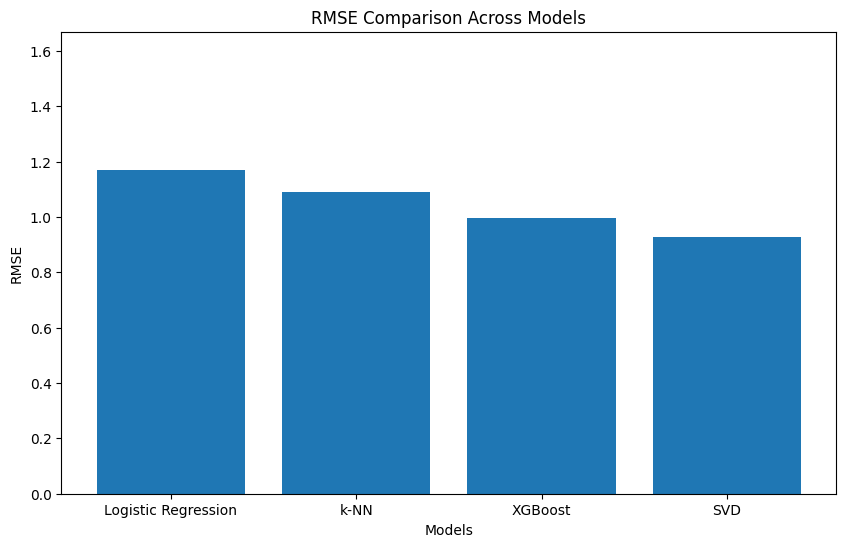

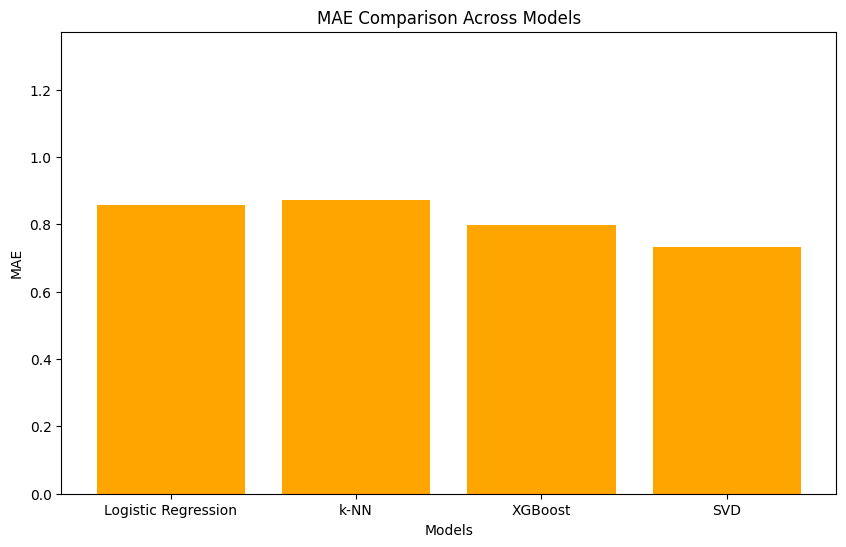

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Updated evaluation results
models = ["Logistic Regression", "k-NN", "XGBoost", "SVD"]
rmse_values = [1.1695, 1.0899, 0.9976, 0.9278]  # Updated RMSE values
mae_values = [0.85595, 0.871945, 0.797335, 0.731238]  # Updated MAE values

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values)
plt.title("RMSE Comparison Across Models")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.ylim(0, max(rmse_values) + 0.5)
plt.show()

# Plot MAE
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color='orange')
plt.title("MAE Comparison Across Models")
plt.xlabel("Models")
plt.ylabel("MAE")
plt.ylim(0, max(mae_values) + 0.5)
plt.show()


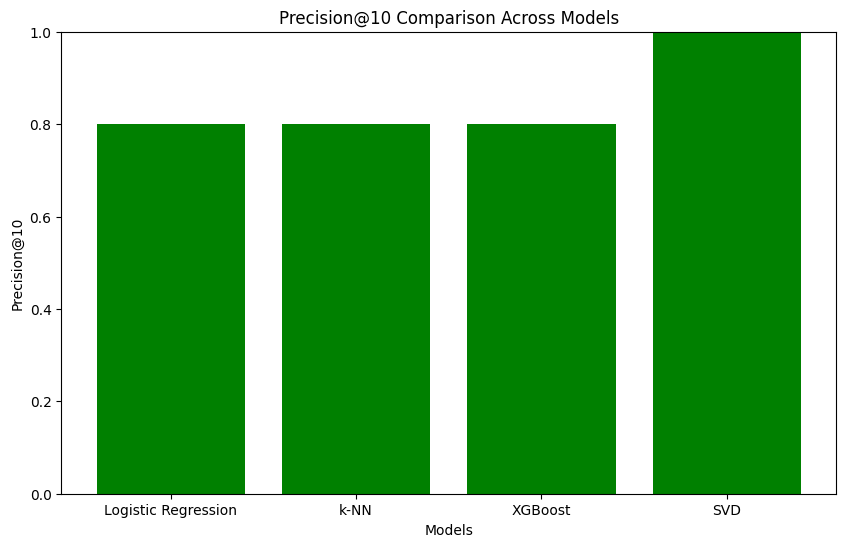

In [ ]:
# Updated Precision@10 values
precision_values = [0.8, 0.8, 0.8, 1.0]  # Updated Precision@10 values

# Plot Precision@10
plt.figure(figsize=(10, 6))
plt.bar(models, precision_values, color='green')
plt.title("Precision@10 Comparison Across Models")
plt.xlabel("Models")
plt.ylabel("Precision@10")
plt.ylim(0, 1.0)  # Precision is between 0 and 1
plt.show()


In [ ]:
!pip install ace_tools

In [ ]:
# Example hybrid dataset structure
import pandas as pd

# Sample user features
user_features = pd.DataFrame({
    "user_id": [1, 2, 3],
    "occupation": ["student", "engineer", "artist"],
    "average_rating_given": [4.2, 3.8, 4.0]
})

# Sample item features
item_features = pd.DataFrame({
    "item_id": [101, 102, 103],
    "genre_Action": [1, 0, 1],
    "genre_Comedy": [0, 1, 0],
    "genre_Drama": [0, 1, 1]
})

# Sample user-item interaction data
user_item_interactions = pd.DataFrame({
    "user_id": [1, 1, 2, 3, 3],
    "item_id": [101, 102, 103, 101, 103],
    "rating": [5, 4, 3, 5, 4]
})

# Merge user and item features with interactions to create a hybrid dataset
hybrid_dataset = user_item_interactions.merge(user_features, on="user_id")
hybrid_dataset = hybrid_dataset.merge(item_features, on="item_id")

# Display the hybrid dataset structure
import ace_tools as tools; tools.display_dataframe_to_user(name="Hybrid Dataset Example", dataframe=hybrid_dataset)


ModuleNotFoundError: No module named 'ace_tools'